# Debug the cues computation

In [1]:
from pykitPIV.ml import PIVEnv, CameraAgent, Rewards, Cues, plot_trajectory
from pykitPIV.flowfield import compute_q_criterion, compute_divergence
from pykitPIV import ParticleSpecs, FlowFieldSpecs, MotionSpecs, ImageSpecs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import cmcrameri.cm as cmc
import numpy as np
import onnxruntime
import tensorflow as tf
import pandas as pd
import h5py
import torch
import sys, os
import time

2025-02-25 15:16:50.171506: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
interrogation_window_size = (40,40)

***

## Initializations

### Prepare specifications for pykitPIV parameters

In [3]:
particle_spec = ParticleSpecs(diameters=(1, 1),
                              distances=(2, 2),
                              densities=(0.4, 0.4),
                              diameter_std=0,
                              seeding_mode='random')

print(particle_spec)

ParticleSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
diameters=(1, 1),
distances=(2, 2),
densities=(0.4, 0.4),
diameter_std=0,
seeding_mode='random',
random_seed=None)


In [4]:
flowfield_spec = FlowFieldSpecs(size=(200, 300),
                                flowfield_type='random smooth',
                                gaussian_filters=(10, 10),
                                n_gaussian_filter_iter=10,
                                displacement=(2, 2))

print(flowfield_spec)

FlowFieldSpecs(n_images=1,
size=(200, 300),
size_buffer=10,
random_seed=None,
flowfield_type='random smooth',
gaussian_filters=(10, 10),
n_gaussian_filter_iter=10,
displacement=(2, 2),
apply_SLM=False,
integral_time_scale=1,
sigma=1,
n_stochastic_particles=1000000,
n_iterations=100)


In [5]:
motion_spec = MotionSpecs(n_steps=10,
                          time_separation=1,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

MotionSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
n_steps=10,
time_separation=1,
particle_loss=(0, 0),
particle_gain=(0, 0))


In [6]:
image_spec = ImageSpecs(exposures=(0.98, 0.98),
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False)

print(image_spec)

ImageSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
exposures=(0.98, 0.98),
maximum_intensity=65535,
laser_beam_thickness=1,
laser_over_exposure=1,
laser_beam_shape=0.95,
alpha=0.125,
clip_intensities=True,
normalize_intensities=False)


In [54]:
sample_every_n = 5

In [69]:
cues_obj = Cues(sample_every_n=sample_every_n, 
                normalize_displacement_vectors=False)

cues_function = cues_obj.sampled_vectors

In [70]:
env = PIVEnv(interrogation_window_size=interrogation_window_size,
             interrogation_window_size_buffer=5,
             cues_function=cues_function,
             particle_spec=particle_spec,
             motion_spec=motion_spec,
             image_spec=image_spec,
             flowfield_spec=flowfield_spec,
             inference_model=None,
             random_seed=None)

In [71]:
camera_position, cues = env.reset()

In [72]:
cues.shape

(1, 128)

In [73]:
cues

array([[-1.04056701e-01, -1.40633760e-01, -1.75127245e-01,
        -2.06267026e-01, -2.33355272e-01, -2.56397238e-01,
        -2.76111920e-01, -2.93826463e-01, -1.05464025e-01,
        -1.32671769e-01, -1.56336877e-01, -1.75469173e-01,
        -1.89709076e-01, -1.99441143e-01, -2.05783210e-01,
        -2.10457231e-01, -1.04010800e-01, -1.21543162e-01,
        -1.34185602e-01, -1.41204962e-01, -1.42547406e-01,
        -1.38937777e-01, -1.31851167e-01, -1.23364603e-01,
        -9.87923337e-02, -1.06927361e-01, -1.09062022e-01,
        -1.04669836e-01, -9.39364440e-02, -7.78499205e-02,
        -5.81614020e-02, -3.72249416e-02, -8.92085904e-02,
        -8.87559358e-02, -8.15265282e-02, -6.71271804e-02,
        -4.58889177e-02, -1.89550865e-02,  1.17602251e-02,
         4.37344741e-02, -7.50392612e-02, -6.72432608e-02,
        -5.22901216e-02, -2.98301065e-02, -2.26251243e-04,
         3.53517694e-02,  7.49612592e-02,  1.16039670e-01,
        -5.64720707e-02, -4.28802299e-02, -2.21705984e-0

In [74]:
n_cues = env.n_cues
n_cues

128

In [75]:
(_, _, H, W) = env.targets_tensor.shape
idx_H = [i for i in range(0, H) if i % sample_every_n == 0]
idx_W = [i for i in range(0, W) if i % sample_every_n == 0]

In [76]:
len(idx_H)

8

In [77]:
len(idx_W)

8

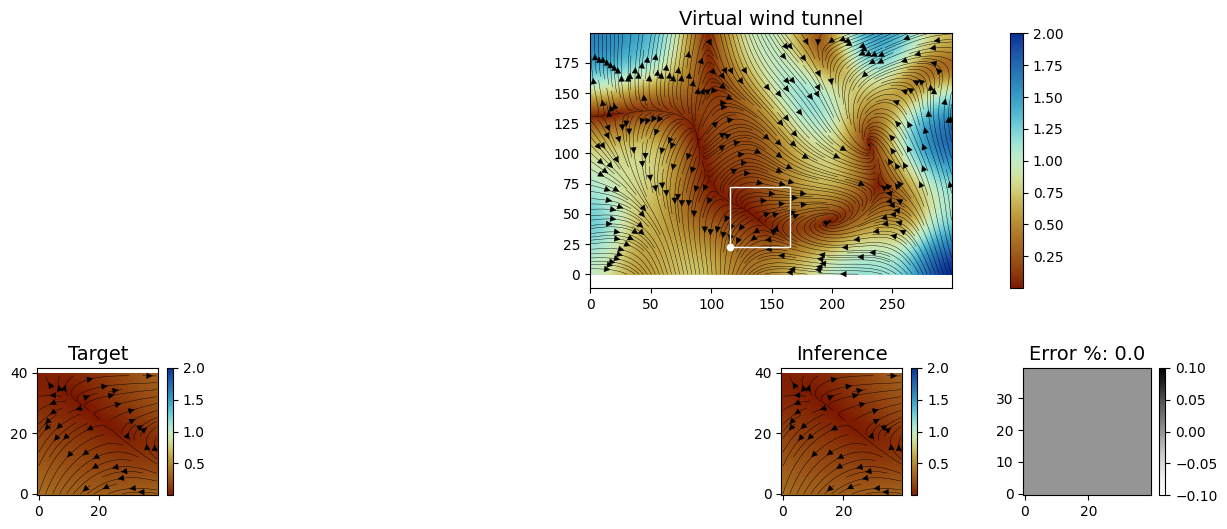

In [78]:
plt = env.render(camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=3,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(15,6));

In [79]:
dx_sample = cues[0,0:int(n_cues/2)]
dx_sample = dx_sample.reshape((len(idx_H),len(idx_W)))
dx_sample

array([[-1.04056701e-01, -1.40633760e-01, -1.75127245e-01,
        -2.06267026e-01, -2.33355272e-01, -2.56397238e-01,
        -2.76111920e-01, -2.93826463e-01],
       [-1.05464025e-01, -1.32671769e-01, -1.56336877e-01,
        -1.75469173e-01, -1.89709076e-01, -1.99441143e-01,
        -2.05783210e-01, -2.10457231e-01],
       [-1.04010800e-01, -1.21543162e-01, -1.34185602e-01,
        -1.41204962e-01, -1.42547406e-01, -1.38937777e-01,
        -1.31851167e-01, -1.23364603e-01],
       [-9.87923337e-02, -1.06927361e-01, -1.09062022e-01,
        -1.04669836e-01, -9.39364440e-02, -7.78499205e-02,
        -5.81614020e-02, -3.72249416e-02],
       [-8.92085904e-02, -8.87559358e-02, -8.15265282e-02,
        -6.71271804e-02, -4.58889177e-02, -1.89550865e-02,
         1.17602251e-02,  4.37344741e-02],
       [-7.50392612e-02, -6.72432608e-02, -5.22901216e-02,
        -2.98301065e-02, -2.26251243e-04,  3.53517694e-02,
         7.49612592e-02,  1.16039670e-01],
       [-5.64720707e-02, -4.288022

In [80]:
dy_sample = cues[0,int(n_cues/2)::]
dy_sample = dy_sample.reshape((len(idx_H),len(idx_W)))
dy_sample

array([[-0.34775509, -0.29389816, -0.23908071, -0.18447606, -0.13113324,
        -0.07999934, -0.03198378,  0.01195893],
       [-0.29273621, -0.24395542, -0.1946765 , -0.14564841, -0.09758128,
        -0.05119224, -0.00727602,  0.0332211 ],
       [-0.23454789, -0.19168925, -0.14897417, -0.10667422, -0.06509995,
        -0.02467343,  0.01399126,  0.05001896],
       [-0.17629377, -0.14003255, -0.10473831, -0.0701701 , -0.03618962,
        -0.00286225,  0.02944876,  0.06001304],
       [-0.12090555, -0.0916825 , -0.06441333, -0.03833047, -0.01281409,
         0.01247779,  0.03749841,  0.06173743],
       [-0.07087256, -0.04884779, -0.02989   , -0.01271369,  0.00379405,
         0.02041565,  0.03747351,  0.05474469],
       [-0.02800463, -0.01304056, -0.00233184,  0.00589344,  0.01322931,
         0.02090926,  0.02965758,  0.03959015],
       [ 0.00673019,  0.01504971,  0.01790726,  0.01750872,  0.0158936 ,
         0.01473228,  0.0151598 ,  0.01766084]])

In [81]:
ds_magnitude = np.sqrt(env.targets_tensor[0,0,:,:]**2 + env.targets_tensor[0,1,:,:]**2)

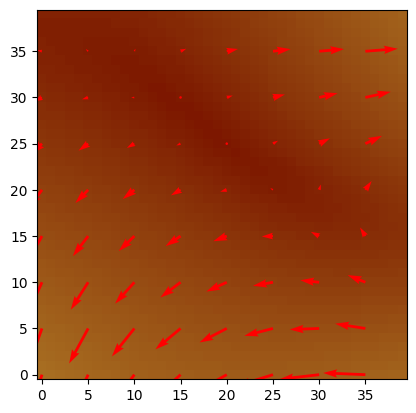

In [82]:
plt.imshow(ds_magnitude, origin='lower', cmap=cmc.roma, vmin=0, vmax=2)
plt.quiver(idx_W, idx_H, dx_sample, dy_sample, color='r')

***
